In [2]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from tqdm import tqdm

import statsmodels.api as sm

import pystan

import pymc3 as pm

import tensorflow as tf
import edward as ed

import warnings
warnings.filterwarnings('ignore')

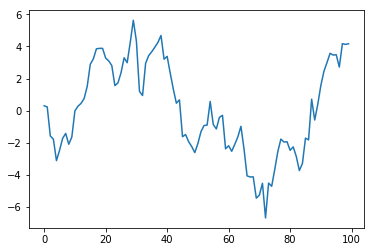

In [4]:
y = np.cumsum(np.random.normal(size=100))
plt.plot(y)
plt.show()

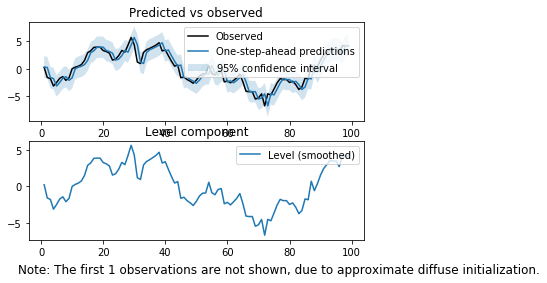

In [5]:
# statsmodels

model = sm.tsa.UnobservedComponents(y, 'local level')
result = model.fit()
result.plot_components()
plt.show()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4eca5dff070c8e9e2e8fbdc5e7560772 NOW.


In file included from /opt/conda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1809:0,
                 from /opt/conda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /opt/conda/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/tmp20trpm4r/stanfit4anon_model_4eca5dff070c8e9e2e8fbdc5e7560772_6222689242566989373.cpp:641:
/opt/conda/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^~~~~~~
In file included from /opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.64.0/boost/numeric/ublas/matrix.hpp:19:0,
                 from /opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.64.0/boost/numeric/odeint/util/ubla

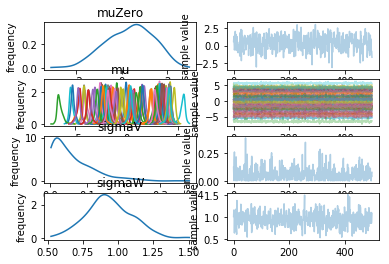

In [7]:
# pystan

model = """
    data {
        int n; # サンプルサイズ
        vector[n] y; # 時系列の値
    }
    parameters {
        real muZero; # 左端
        vector[n] mu; # 確率的レベル
        real<lower=0> sigmaV; # 観測誤差の大きさ
        real<lower=0> sigmaW; # 過程誤差の大きさ
    }
    model {
        # 状態方程式
        mu[1] ~ normal(muZero, sqrt(sigmaW));
        for(i in 2:n) {
            mu[i] ~ normal(mu[i-1], sqrt(sigmaW));
        }
        
        # 観測方程式
        for(i in 1:n) {
            y[i] ~ normal(mu[i], sqrt(sigmaV));
        }
    }
"""
fit = pystan.stan(model_code=model, data={'n': 100, 'y': y}, iter=1000, chains=1)
fit.plot()
plt.show()

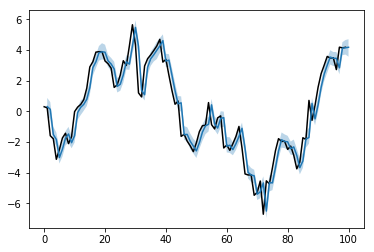

In [8]:
la = fit.extract()

pred = la['mu'].mean(axis=0)
mu_lower, mu_upper = np.percentile(la['mu'], q=[2.5, 97.5], axis=0)

plt.plot(list(range(len(y)+1)), list(y)+[None], color='black')
plt.plot(list(range(1, len(y)+1)), pred)
plt.fill_between(list(range(1, len(y)+1)), mu_lower, mu_upper, alpha=0.3)
plt.show()

logp = -78.335, ||grad|| = 0.23348: 100%|██████████| 67/67 [00:00<00:00, 432.54it/s]  
INFO:pymc3:Sequential sampling (2 chains in 1 job)
INFO:pymc3:NUTS: [sigmaV, mu99, mu98, mu97, mu96, mu95, mu94, mu93, mu92, mu91, mu90, mu89, mu88, mu87, mu86, mu85, mu84, mu83, mu82, mu81, mu80, mu79, mu78, mu77, mu76, mu75, mu74, mu73, mu72, mu71, mu70, mu69, mu68, mu67, mu66, mu65, mu64, mu63, mu62, mu61, mu60, mu59, mu58, mu57, mu56, mu55, mu54, mu53, mu52, mu51, mu50, mu49, mu48, mu47, mu46, mu45, mu44, mu43, mu42, mu41, mu40, mu39, mu38, mu37, mu36, mu35, mu34, mu33, mu32, mu31, mu30, mu29, mu28, mu27, mu26, mu25, mu24, mu23, mu22, mu21, mu20, mu19, mu18, mu17, mu16, mu15, mu14, mu13, mu12, mu11, mu10, mu9, mu8, mu7, mu6, mu5, mu4, mu3, mu2, mu1, mu0, sigmaW, muZero]
100%|██████████| 1500/1500 [00:28<00:00, 53.29it/s]
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89eb4604e0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f89ebba87b8>]], dtype=object)

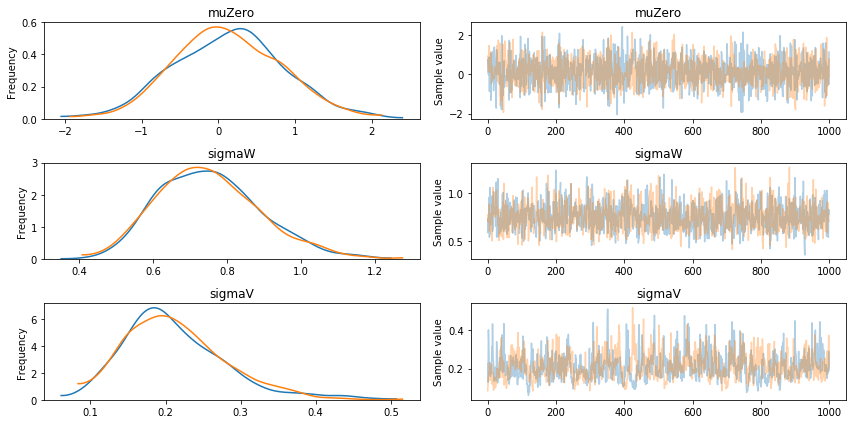

In [9]:
# pymc3

N = len(y)
T = 1000

with pm.Model() as model:
    
    muZero = pm.Normal(name='muZero', mu=0.0, tau=1.0)
    sigmaW = pm.InverseGamma(name='sigmaW', alpha=1.0, beta=1.0)
    
    mu = [0]*N
    mu[0] = pm.Normal(name='mu0', mu=muZero, tau=1/sigmaW)
    for n in range(1, N):
        mu[n] = pm.Normal(name='mu'+str(n), mu=mu[n-1], tau=1/sigmaW)
    
    sigmaV = pm.InverseGamma(name='sigmaV', alpha=1.0, beta=1.0)
    y_pre = pm.Normal('y_pre', mu=mu, tau=1/sigmaV, observed=y)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(T, step, start=start)
    
pm.traceplot(trace, varnames=['muZero', 'sigmaW', 'sigmaV'])

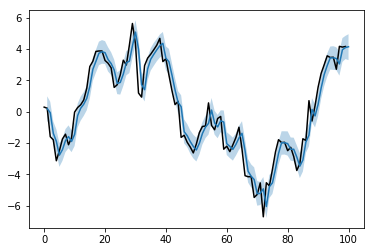

In [10]:
mu_samples = np.array([trace['mu'+str(i)] for i in range(N)])
pred = mu_samples.mean(axis=1)
mu_lower, mu_upper = np.percentile(mu_samples, q=[2.5, 97.5], axis=1)

plt.plot(list(range(len(y)+1)), list(y)+[None], color='black')
plt.plot(list(range(1, len(y)+1)), pred)
plt.fill_between(list(range(1, len(y)+1)), mu_lower, mu_upper, alpha=0.3)
plt.show()

In [11]:
# edward

from edward.models import Normal, InverseGamma, Empirical

N = len(y)
T = 1000

muZero = Normal(loc=0.0, scale=1.0)
sigmaW = InverseGamma(concentration=1.0, rate=1.0)

mu = [0]*N
mu[0] = Normal(loc=muZero, scale=sigmaW)
for n in range(1, N):
    mu[n] = Normal(loc=mu[n-1], scale=sigmaW)

sigmaV = InverseGamma(concentration=1.0, rate=1.0)
y_pre = Normal(loc=tf.stack(mu), scale=sigmaV)

qmuZero = Empirical(tf.Variable(tf.zeros(T)))
qsigmaW = Empirical(tf.Variable(tf.zeros(T)))
qmu = [Empirical(tf.Variable(tf.zeros(T))) for n in range(N)]
qsigmaV = Empirical(tf.Variable(tf.zeros(T)))

latent_vars = {m: qm for m, qm in zip(mu, qmu)}
latent_vars[muZero] = qmuZero
latent_vars[sigmaW] = qsigmaW
latent_vars[sigmaV] = qsigmaV
inference = ed.HMC(latent_vars, data={y_pre: y})
inference.run(n_iter=T)

1000/1000 [100%] ██████████████████████████████ Elapsed: 35s | Acceptance Rate: 0.340


100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


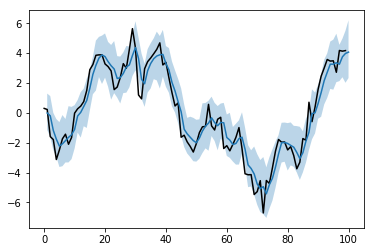

In [12]:
pred = np.zeros((len(y)), dtype=np.float32)
mu_lower = np.zeros((len(y)), dtype=np.float32)
mu_upper = np.zeros((len(y)), dtype=np.float32)

for i, _qmu in enumerate(tqdm(qmu)):
    
    qmu_sample = _qmu.sample(1000).eval()
    _pred = qmu_sample.mean()
    _mu_lower, _mu_upper = np.percentile(qmu_sample, q=[2.5, 97.5], axis=0)
    
    pred[i] = _pred
    mu_lower[i] = _mu_lower
    mu_upper[i] = _mu_upper
    
plt.plot(list(range(len(y)+1)), list(y)+[None], color='black')
plt.plot(list(range(1, len(y)+1)), pred)
plt.fill_between(list(range(1, len(y)+1)), mu_lower, mu_upper, alpha=0.3)
plt.show()